In [1]:
import os
import dotenv

import pandas as pd
import pandahouse as ph
from scipy import stats
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dotenv.load_dotenv()
connection = {'host': os.getenv('host'),
                      'database':os.getenv('extract_database'),
                      'user':os.getenv('extract_user'), 
                      'password':os.getenv('extract_password')
                     }

query = '''
SELECT  exp_group,
        user_id,
        sum(action='like') AS likes,
        sum(action='view') AS views,
        likes/views AS ctr
FROM    {db}.feed_actions
WHERE   toDate(time) BETWEEN '2023-03-02' AND '2023-03-08'
        AND exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)


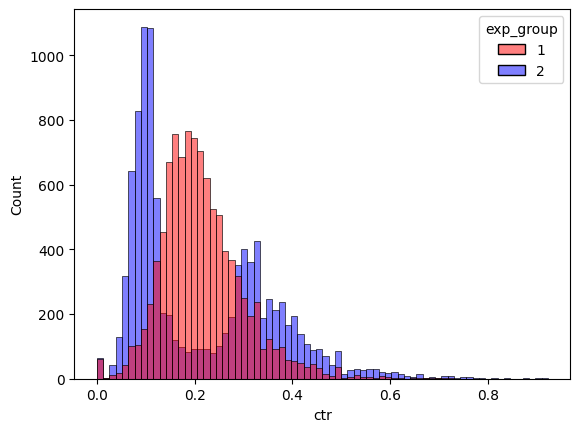

In [2]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [3]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Распределение группы с новой функциональностью сильно скошено. На нем использовать t-test нельзя. 
Данный тест не показал значимых различий, хотя даже визуально видно, что они есть.

Можно попробовать сгладить CTR и снова проверить t-test

<Axes: xlabel='smothed_ctr', ylabel='Count'>

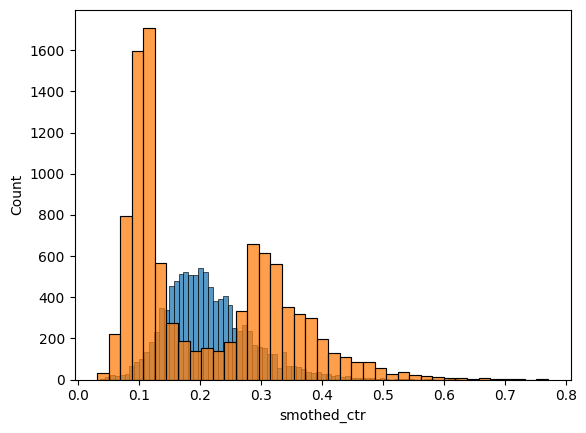

In [7]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_ctr, 
             kde = False)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_ctr, 
             kde = False)

In [8]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.022376981555855876)

После сглаживания t-test уже показал значимые различия Однако у сглаживания CTR нет теоретической гарантии, что его направленность совпадает с направленностью общего количества кликов. Поэтому проверим используем более подходящий в данном случае тест Манна-Уитни

In [9]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                        df[df.exp_group == 2].ctr))

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
В 55.51 % случаев A > B. Должно получиться около 50%


В случае теста Манна-Уитни есть статистически значимые различия между группами. Причем CTR группы А больше CTR группы В. Получается, что новый функционал, наоборот, снизил отслеживаемую метрику

Попробем еще Пуассоновский бутстреп

<Axes: ylabel='Count'>

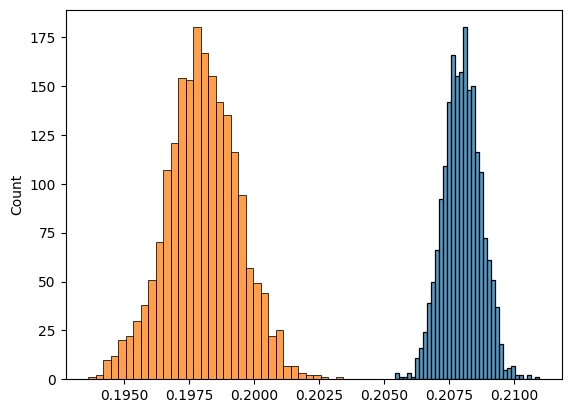

In [10]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

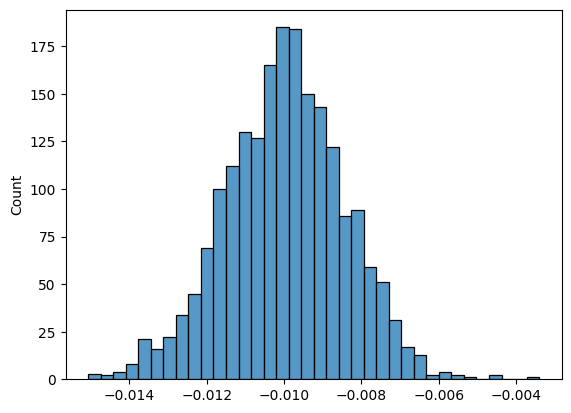

In [11]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)


Очень наглядно видно, что в группах есть статистические различия(распределения даже не пересекаются) и, что внедрение новой системы рекомендаций снизило CTR

In [12]:
q = """

SELECT  exp_group, 
        bucket,
        sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
   WHERE   toDate(time) BETWEEN '2023-03-02' AND '2023-03-08'
        AND exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)


<Axes: xlabel='bucket_ctr', ylabel='Count'>

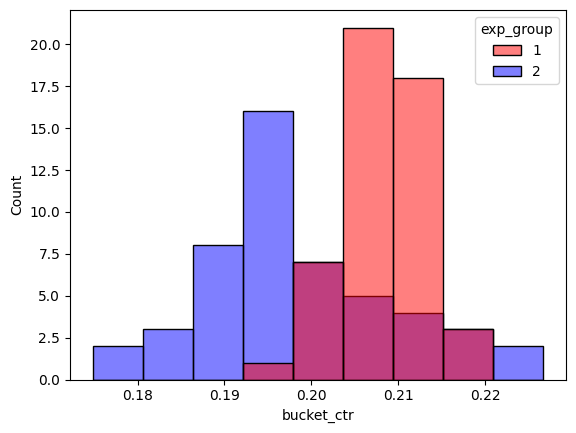

In [13]:
sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

После бакетного преобразования распределения приобрели более нормальный вид и, наши тесты слали работать корректнее, например,при t-test уже хорошо видны различия

In [14]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [15]:
#и t-тест тоже

stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [16]:
df.groupby('exp_group').views.sum()


exp_group
1    668236
2    658310
Name: views, dtype: uint64

In [18]:
df.groupby('exp_group').likes.sum()


exp_group
1    139011
2    130385
Name: likes, dtype: uint64

<strong>Вывод:</strong> Раскатывать алгоритм на всех пользователей нельзя, так как он снижает глобальный CTR.